In [1]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

In [2]:
##############################################################################
# 1) Define devices:  noiseless ("default.qubit"),  noisy ("default.mixed").
##############################################################################

# noiseless device
dev_exact = qml.device("default.qubit", wires = 2, shots = None)

# niosy device (simple amplitude + phase damping model)
# "shots=1024" is used so we can mimic a finite-sample experiment.
dev_noisy = qml.device("default.mixed", wires = 2, shots = 1024)

In [3]:
##############################################################################
# 2) Define the H2 Hamiltonian, the ansatz, and nuclear repulsion shift.
##############################################################################

# H2 Hamiltonian coefficients
coeffs = {
    'c0': -1.0523732,
    'c1':  0.39793742,
    'c2': -0.3979374,
    'c3': -0.0112801,
    'c4':  0.18093119
}
# Nuclear repulsion shift for H2 at R=0.75 A
nuclear_repulsion = 0.7199689944489797

coefs_list = [
    coeffs['c0'],
    coeffs['c1'],
    coeffs['c2'],
    coeffs['c3'],
    coeffs['c4']
]
ops_list = [
    qml.Identity(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliZ(0)   @ qml.Identity(1),
    qml.PauliZ(0)   @ qml.PauliZ(1),
    qml.PauliX(0)   @ qml.PauliX(1)
]
H = qml.Hamiltonian(coefs_list, ops_list)

In [4]:
# ansatz with two parameters repeated to some "circuit_depth".
def ansatz(params, circuit_depth = 2, noisy = False):
    """
        applies RY-RZ layers plus CNOTs, optionally inserting amplitude & phase damping.
    """
    theta1, theta2 = params

    # initial single-qubit gates
    for w in range(2):
        qml.RY(theta1, wires=w)
        qml.RZ(theta1, wires=w)

    # optional noise
    if noisy:
        # amplitude & phase damping
        gamma = 0.1
        qml.AmplitudeDamping(gamma, wires=0)
        phi = 0.1
        qml.PhaseDamping(phi, wires=1)

    # repeated pattern: chain of CNOTs + single-qubit rotations
    for _ in range(circuit_depth):
        # CNOT in a chain [0->1]
        qml.CNOT(wires=[0,1])
        # single-qubit gates again
        for w in range(2):
            qml.RY(theta2, wires=w)
            qml.RZ(theta2, wires=w)


In [5]:
##############################################################################
# 3) define QNodes and cost functions for exact, noisy, and CDR runs.
##############################################################################

@qml.qnode(dev_exact)
def circuit_exact(params, circuit_depth=2):
    ansatz(params, circuit_depth=circuit_depth, noisy=False)
    return qml.expval(H)

@qml.qnode(dev_noisy)
def circuit_noisy(params, circuit_depth=2):
    ansatz(params, circuit_depth=circuit_depth, noisy=True)
    return qml.expval(H)

def cost_exact(params, circuit_depth=2):
    return circuit_exact(params, circuit_depth=circuit_depth) + nuclear_repulsion

def cost_noisy(params, circuit_depth=2):
    return circuit_noisy(params, circuit_depth=circuit_depth) + nuclear_repulsion


In [6]:
##############################################################################
# 4) random near-Clifford circuit generation for training.
##############################################################################

def random_clifford_params(params, snap_prob = 0.3):
    """
        with probability 'snap_prob' per angle, snap it to the nearest multiple of pi/2,
        making it effectively a Clifford rotation. otherwise keep original angle.
    """
    out = []
    for angle in params:
        if np.random.rand() < snap_prob:
            # snap to multiple of pi/2
            # we'll pick whichever multiple of pi/2 is nearest, or pick randomly:
            # multiples of pi/2 in [0, 2π) are: 0, π/2, π, 3π/2
            # you can also choose from -∞,∞ but mod 2π. we do mod 2π:
            angle_mod_2pi = angle % (2*np.pi)
            multiples = np.array([0., np.pi/2, np.pi, 3*np.pi/2])
            # find whichever of these is nearest
            diffs = np.abs(multiples - angle_mod_2pi)
            idx = np.argmin(diffs)
            # we then re-insert the integer multiple, but keep same quadrant shift from original
            snapped_val = multiples[idx]  # This is in [0, 2π)
            # we can either just take snapped_val or do angle - angle_mod_2pi + snapped_val
            # so we preserve the same "2π offset" as the original. usually it doesn't matter
            # because angles are periodic
            base = angle - angle_mod_2pi
            out.append(base + snapped_val)
        else:
            # keep original
            out.append(angle)
    return np.array(out)

In [7]:
def generate_cdr_training_data(params, n_train=10, circuit_depth=2):
    """
        generate training circuits near the original params, measure them exactly and noisily.
        
        returns:
            (noisy_vals, exact_vals)
    """
    noisy_vals = []
    exact_vals = []
    for _ in range(n_train):
        # random near-Clifford
        cparams = random_clifford_params(params, snap_prob = 0.3)
        
        # exact energy
        E_exact = cost_exact(cparams, circuit_depth = circuit_depth)
        # noisy energy
        E_noisy = cost_noisy(cparams, circuit_depth = circuit_depth)
        
        exact_vals.append(E_exact)
        noisy_vals.append(E_noisy)
    return np.array(noisy_vals), np.array(exact_vals)

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

def cdr_model(noisy_vals, exact_vals, test_val, model="linear", alpha=0.1):
    """
    Fits a regression model (linear, ridge, or lasso) on (noisy_vals, exact_vals)
    and then applies it to test_val to obtain the mitigated energy.

    Args:
        noisy_vals (ndarray): 1D array of noisy energies from near-Clifford circuits.
        exact_vals (ndarray): 1D array of exact energies from near-Clifford circuits.
        test_val   (float):   The noisy energy for the *current* circuit,
                              which we want to mitigate.
        model (str): "linear" or "ridge" or "lasso"
        alpha (float): regularization strength, used for ridge and lasso.

    Returns:
        float: the mitigated energy predicted by the chosen model.
    """
    # 1) choose a model
    if model == "linear":
        reg = LinearRegression()
    elif model == "ridge":
        reg = Ridge(alpha=alpha)
    elif model == "lasso":
        reg = Lasso(alpha=alpha)
    else:
        raise ValueError(f"Unknown model type '{model}'. Choose from 'linear', 'ridge', or 'lasso'.")

    # 2) Fit the chosen regression to our training data
    reg.fit(noisy_vals.reshape(-1, 1), exact_vals)

    # 3) Predict the corrected (CDR) value for the test circuit
    return reg.predict([[test_val]])[0]

In [9]:
##############################################################################
# 5) define cost function that uses CDR mitigation on each iteration.
##############################################################################

def cost_cdr(params, circuit_depth=2, n_train=10, model="linear", alpha=0.1):
    """
    cost function that does CDR on each iteration.
    We can pass 'model="ridge"' or 'model="lasso"' to use those instead.
    """
    # 1) generate near-Clifford training data
    noisy_vals, exact_vals = generate_cdr_training_data(params, n_train=n_train, circuit_depth=circuit_depth)
    
    # 2) measure the original circuit in the noisy device
    test_noisy = cost_noisy(params, circuit_depth=circuit_depth)
    
    # 3) mitigate with the chosen model
    E_cdr = cdr_model(noisy_vals, exact_vals, test_noisy, model=model, alpha=alpha)
    return E_cdr

In [10]:
##############################################################################
# 6) Run three separate optimizations: exact, noisy, and CDR.
##############################################################################

# We'll store iteration histories
history_exact = []
history_noisy = []
history_cdr_linear = []
history_cdr_ridge = []
history_cdr_lasso = []

# for reproducibility
# np.random.seed(23)

# optimization parameters ("initial guess")
init_params = np.array([np.pi/2, np.pi/2])
circuit_depth = 2
maxiter = 50

In [11]:
# callback functions simply record the energies at each iteration
def cb_exact(xk):
    history_exact.append(cost_exact(xk, circuit_depth = circuit_depth))

def cb_noisy(xk):
    history_noisy.append(cost_noisy(xk, circuit_depth = circuit_depth))

def cb_cdr_linear(xk):
    """
        callback for the linear CDR regression
    """
    val = cost_cdr(xk, circuit_depth = circuit_depth, n_train = 200, model = "linear")
    history_cdr_linear.append(val)

def cb_cdr_ridge(xk):
    """
        callback for the ridge CDR regression
    """
    val = cost_cdr(xk, circuit_depth = circuit_depth, n_train = 200, model = "ridge", alpha = 0.01)
    history_cdr_ridge.append(val)

def cb_cdr_lasso(xk):
    """
        callback for the lasso CDR regression
    """
    val = cost_cdr(xk, circuit_depth = circuit_depth, n_train = 200, model = "lasso", alpha = 0.001)
    history_cdr_lasso.append(val)


## Exact optimization

In [12]:
# 6a) exact optimization
res_exact = minimize(
    fun = lambda x: cost_exact(x, circuit_depth=circuit_depth),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_exact,
    options = {"maxiter": maxiter, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   43   F =-7.631186E-01    MAXCV = 0.000000E+00
   X = 2.237621E+00   1.394551E+00


## Noisy optimization

In [13]:
# 6b) Noisy optimization
res_noisy = minimize(
    fun = lambda x: cost_noisy(x, circuit_depth=circuit_depth),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_noisy,
    options = {"maxiter": maxiter, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   29   F =-7.127503E-01    MAXCV = 0.000000E+00
   X = 2.390281E+00   1.451629E+00


## CDR Optimizatoin

In [14]:
# 6c) CDR optimization
#    (We do the entire optimization using the cost_cdr function, 
#    so the training data is re-generated at each iteration.)
res_cdr_linear = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth=circuit_depth, n_train=100, model="linear"),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_linear,
    options = {"maxiter": maxiter, "disp": True}
)

# 6d) CDR-Ridge
res_cdr_ridge = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth=circuit_depth, n_train=100, model="ridge", alpha=0.01),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_ridge,
    options = {"maxiter": maxiter, "disp": True}
)

# 6e) CDR-Lasso
res_cdr_lasso = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth=circuit_depth, n_train=100, model="lasso", alpha=0.005),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_lasso,
    options = {"maxiter": maxiter, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   34   F =-7.130045E-01    MAXCV = 0.000000E+00
   X = 2.476078E+00   1.304459E+00

   Normal return from subroutine COBYLA

   NFVALS =   30   F =-7.288109E-01    MAXCV = 0.000000E+00
   X = 2.320161E+00   1.262023E+00


/Users/ajlasacic/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(



   Normal return from subroutine COBYLA

   NFVALS =   34   F =-7.088352E-01    MAXCV = 0.000000E+00
   X = 2.377782E+00   1.423886E+00


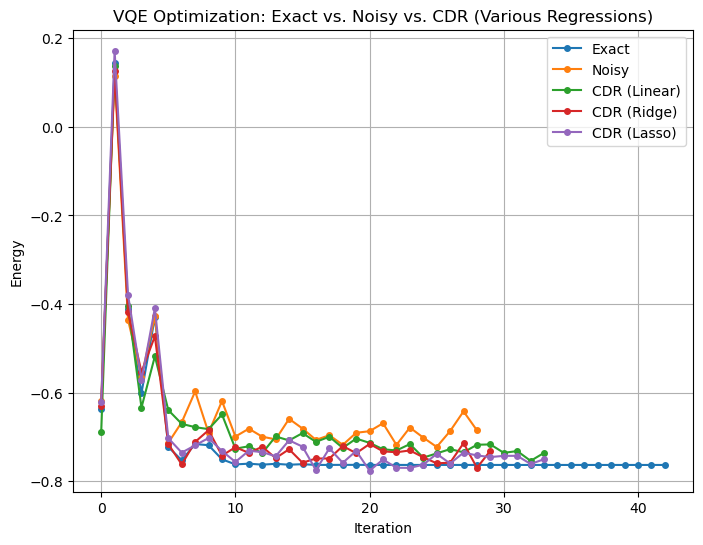

Final results after optimization:
Exact final parameters = [2.23762072 1.39455062],  energy = -0.763119
Noisy final parameters = [2.3902808 1.4516289],  energy = -0.712750
--------
CDR (Linear) final parameters = [2.47607806 1.30445871],  energy = -0.713004
CDR (Ridge)  final parameters = [2.32016091 1.26202318],   energy = -0.728811
CDR (Lasso)  final parameters = [2.3777818  1.42388627],   energy = -0.708835


In [15]:
##############################################################################
# 7) plot the results
##############################################################################
plt.figure(figsize=(8,6))

plt.plot(history_exact, "-o", markersize=4, label="Exact")
plt.plot(history_noisy, "-o", markersize=4, label="Noisy")
plt.plot(history_cdr_linear, "-o", markersize=4, label="CDR (Linear)")
plt.plot(history_cdr_ridge, "-o", markersize=4, label="CDR (Ridge)")
plt.plot(history_cdr_lasso, "-o", markersize=4, label="CDR (Lasso)")

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Optimization: Exact vs. Noisy vs. CDR (Various Regressions)")
plt.legend()
plt.grid(True)
plt.show()

# Print final results
print("================================")
print("Final results after optimization:")
print(f"Exact final parameters = {res_exact.x},  energy = {res_exact.fun:.6f}")
print(f"Noisy final parameters = {res_noisy.x},  energy = {res_noisy.fun:.6f}")
print("--------")
print(f"CDR (Linear) final parameters = {res_cdr_linear.x},  energy = {res_cdr_linear.fun:.6f}")
print(f"CDR (Ridge)  final parameters = {res_cdr_ridge.x},   energy = {res_cdr_ridge.fun:.6f}")
print(f"CDR (Lasso)  final parameters = {res_cdr_lasso.x},   energy = {res_cdr_lasso.fun:.6f}")

## Smooth line plotting

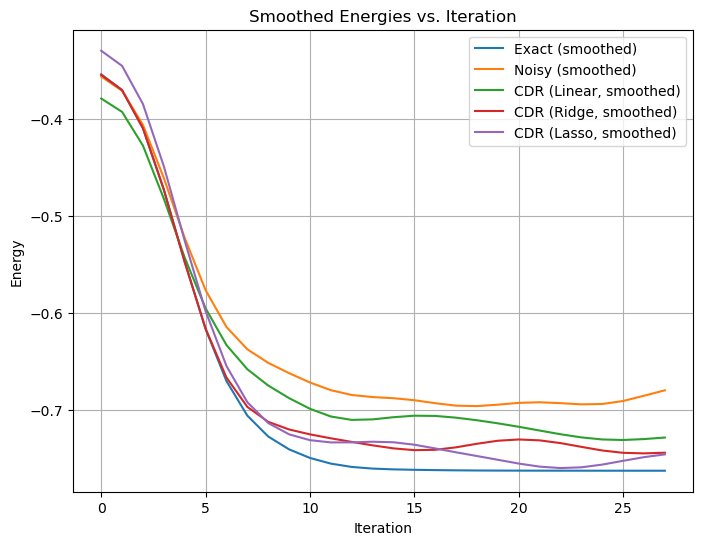

In [17]:
from scipy.ndimage import gaussian_filter1d

##############################################################################
# 8) smoothed version
##############################################################################
ysmoothed_exact  = gaussian_filter1d(history_exact,         sigma = 2)
ysmoothed_noisy  = gaussian_filter1d(history_noisy,         sigma = 2)
ysmoothed_linear = gaussian_filter1d(history_cdr_linear,    sigma = 2)
ysmoothed_ridge  = gaussian_filter1d(history_cdr_ridge,     sigma = 2)
ysmoothed_lasso  = gaussian_filter1d(history_cdr_lasso,     sigma = 2)

plt.figure(figsize=(8,6))
plt.plot(ysmoothed_exact[:28],  label="Exact (smoothed)")
plt.plot(ysmoothed_noisy[:28],  label="Noisy (smoothed)")
plt.plot(ysmoothed_linear[:28], label="CDR (Linear, smoothed)")
plt.plot(ysmoothed_ridge[:28],  label="CDR (Ridge, smoothed)")
plt.plot(ysmoothed_lasso[:28],  label="CDR (Lasso, smoothed)")

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Smoothed Energies vs. Iteration")
plt.legend()
plt.grid(True)
plt.show()